In [15]:
import pandas as pd
import matplotlib.pyplot as plt

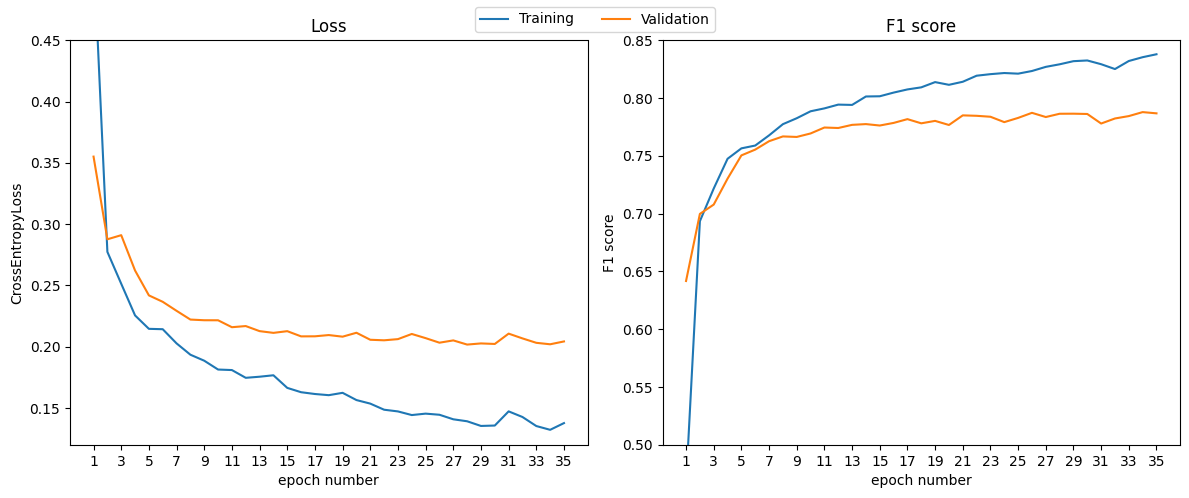

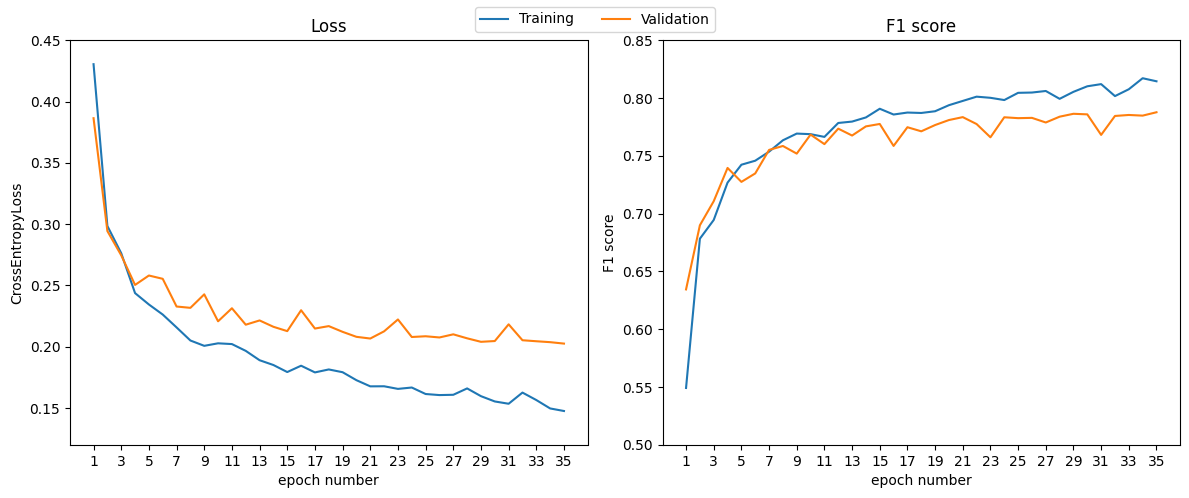

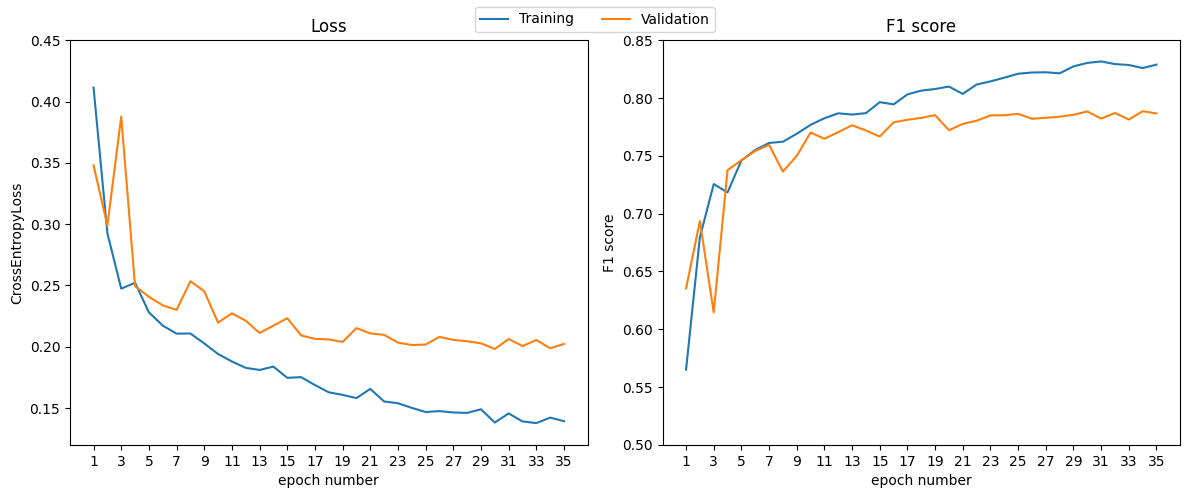

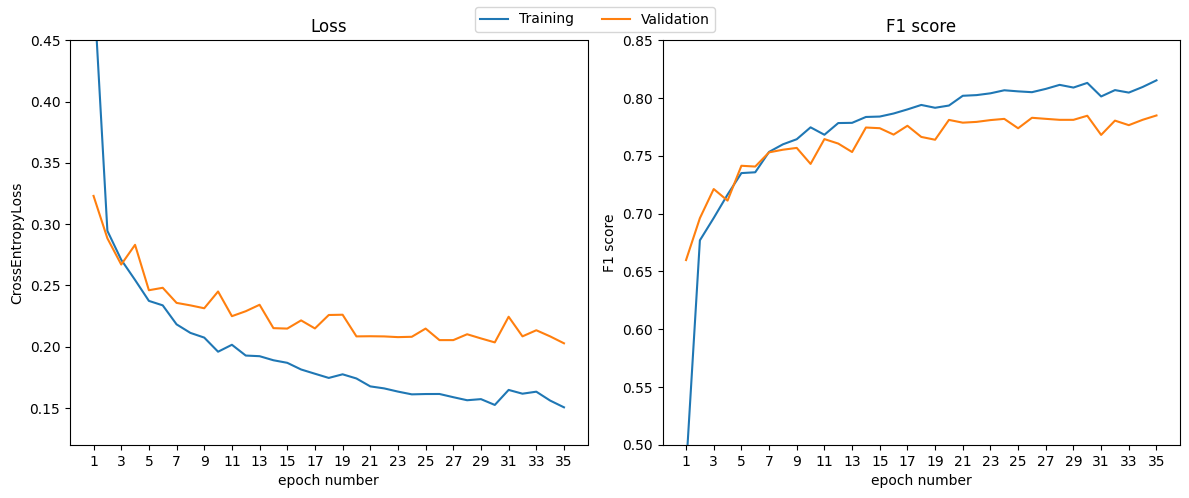

In [16]:
model_names = ['UNet11_e35_s256_b9_noaugm', 'UNet11_e35_s256_b9_jit', 'UNet11_prep_e35_s256_b9_noaugm', 'UNet11_prep_e35_s256_b9_jit']
for nm_model in model_names:
    df = pd.read_csv('models/'+nm_model+'_stats.csv')
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
    plt.setp((ax1,ax2), xticks=range(1, len(df['epoch number']), 2))
    ax1.plot(df['epoch number'],df['train loss'], label='Training')
    ax1.plot(df['epoch number'],df['validation loss'], label='Validation')
    ax1.set_title("Loss")
    ax1.set_ylabel('CrossEntropyLoss')
    ax1.set_ylim([.12, .45])
    ax1.set_xlabel('epoch number')
    ax2.plot(df['epoch number'],df['train f1 score'])
    ax2.plot(df['epoch number'],df['validation f1 score'])
    ax2.set_title("shares x with main")
    ax2.set_title("F1 score")
    ax2.set_ylabel('F1 score')
    ax2.set_ylim([.5, .85])
    ax2.set_xlabel('epoch number')
    fig.tight_layout()
    fig.legend(*ax1.get_legend_handles_labels(),
                loc='upper center', ncol=4)
    # plt.savefig('models/'+nm_model+'_plot.jpg')
    

In [99]:
from collections import defaultdict
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import ternausnet.models
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.augmentations.transforms as T
from albumentations.pytorch import ToTensorV2

from segmentation_models_pytorch.losses import DiceLoss 
import segmentation_models_pytorch as smp
import glob
from matplotlib.colors import from_levels_and_colors
import numpy as np

cudnn.benchmark = True

In [18]:
model_name = "UNet11"
batch_size = 9
epochs_num = 35
img_size = 256
lr = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = getattr(ternausnet.models, 'UNet11')(pretrained=True)
model = model.to(device)

criterion = DiceLoss(mode='binary').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 255] = 1
    return mask

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

class SegmDataset(Dataset):
    def __init__(self, images_paths, transform=None):
        self.images_paths = images_paths
        self.transform = transform

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        image_path = self.images_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        original_size = tuple(image.shape[:2])

        mask_path = str(image_path).replace("/img\\", "/segm\\")
        if mask_path.split('\\')[-1][0] !='f' and (mask_path.split('\\')[-1].split('.')[-1] == 'jpg' or mask_path.split('\\')[-1].split('.')[-1] == 'JPG'):
            mask_path = mask_path.replace('.jpg', '.tif').replace('.JPG', '.tif')
        mask = plt.imread(mask_path)
        mask = preprocess_mask(mask)        
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        if len(mask.shape) == 3:
            mask=mask[:,:, 0]
        return image, mask, original_size


data_transforms = {
    'test': A.Compose([
        A.Resize(img_size,img_size),
        T.Normalize([0.3998, 0.1676, 0.0636], [0.2762, 0.1356, 0.0666]),
        ToTensorV2()
        ])
}

def predict(model):
    phase = 'test'
    model.eval()
    predictions = []
    metric_monitor = MetricMonitor()
    stream = tqdm(loaders[phase])
    with torch.no_grad():
        for i, (images, target, (original_heights, original_widths)) in enumerate(stream, start=1):
            images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(images).squeeze(1)

            loss = criterion(output, target)
            tp, fp, fn, tn = smp.metrics.get_stats(output, target.type(torch.int), mode='binary', threshold=0.5)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
            f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro-imagewise")
            accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise")
            recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
            precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro-imagewise")
            specificity = smp.metrics.specificity(tp, fp, fn, tn, reduction="micro-imagewise")

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("iou score", iou_score.item())
            metric_monitor.update("f1 score", f1_score.item())
            metric_monitor.update("f2 score", f2_score.item())
            metric_monitor.update("accuracy", accuracy.item())
            metric_monitor.update("recall", recall.item())
            metric_monitor.update("precision", precision.item())
            metric_monitor.update("specificity", specificity.item())

            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            probabilities = probabilities.cpu().numpy()
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, probability, original_height, original_width in zip(
                predicted_masks, probabilities, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, probability, original_height, original_width))
            stream.set_description(
                    "{phase}: {metric_monitor}".format(phase=phase, metric_monitor=metric_monitor)
                )
    return predictions

train size:  800
val size:  230
test size:  50


c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [120]:
rand_idx = int(random.random() * 50)

test: Loss: 0.200 | iou score: 0.670 | f1 score: 0.797 | f2 score: 0.783 | accuracy: 0.970 | recall: 0.776 | precision: 0.825 | specificity: 0.986: 100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


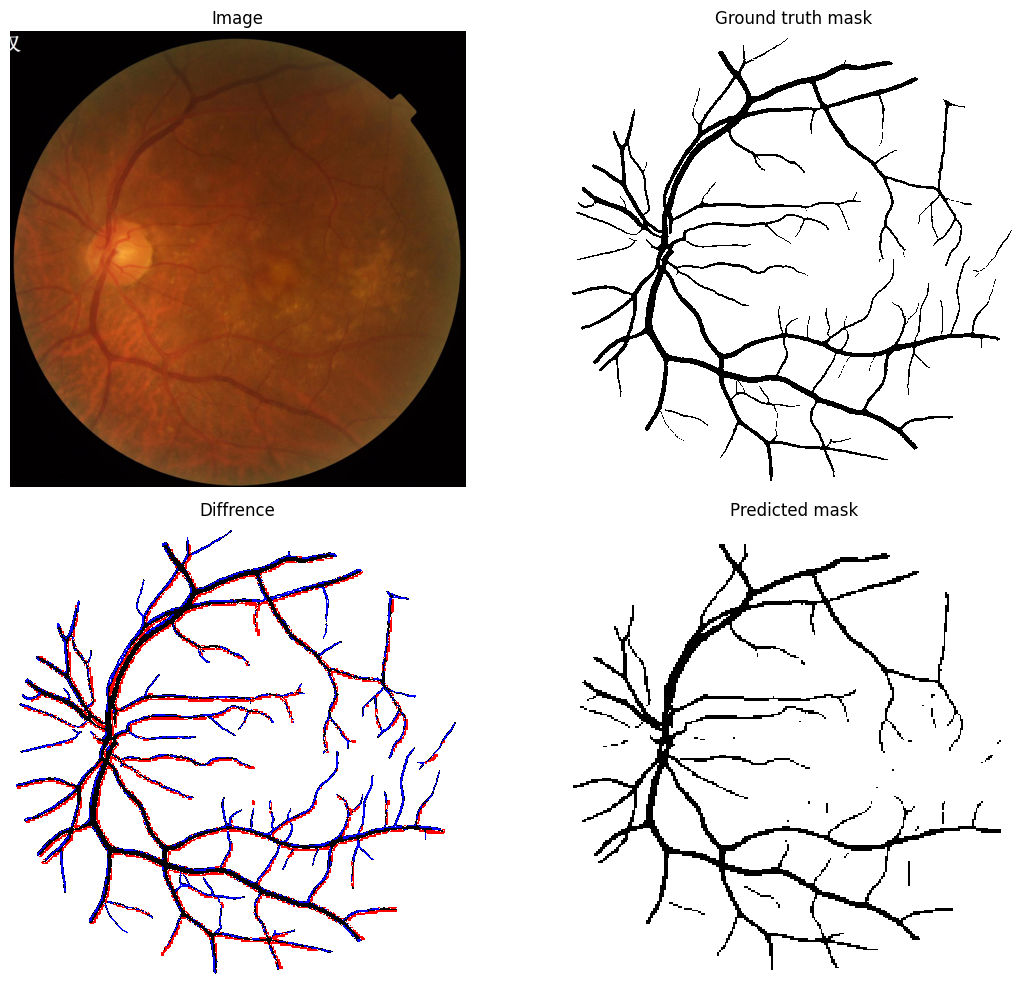

test: Loss: 0.199 | iou score: 0.675 | f1 score: 0.801 | f2 score: 0.800 | accuracy: 0.970 | recall: 0.801 | precision: 0.807 | specificity: 0.983: 100%|██████████| 6/6 [00:17<00:00,  2.88s/it]


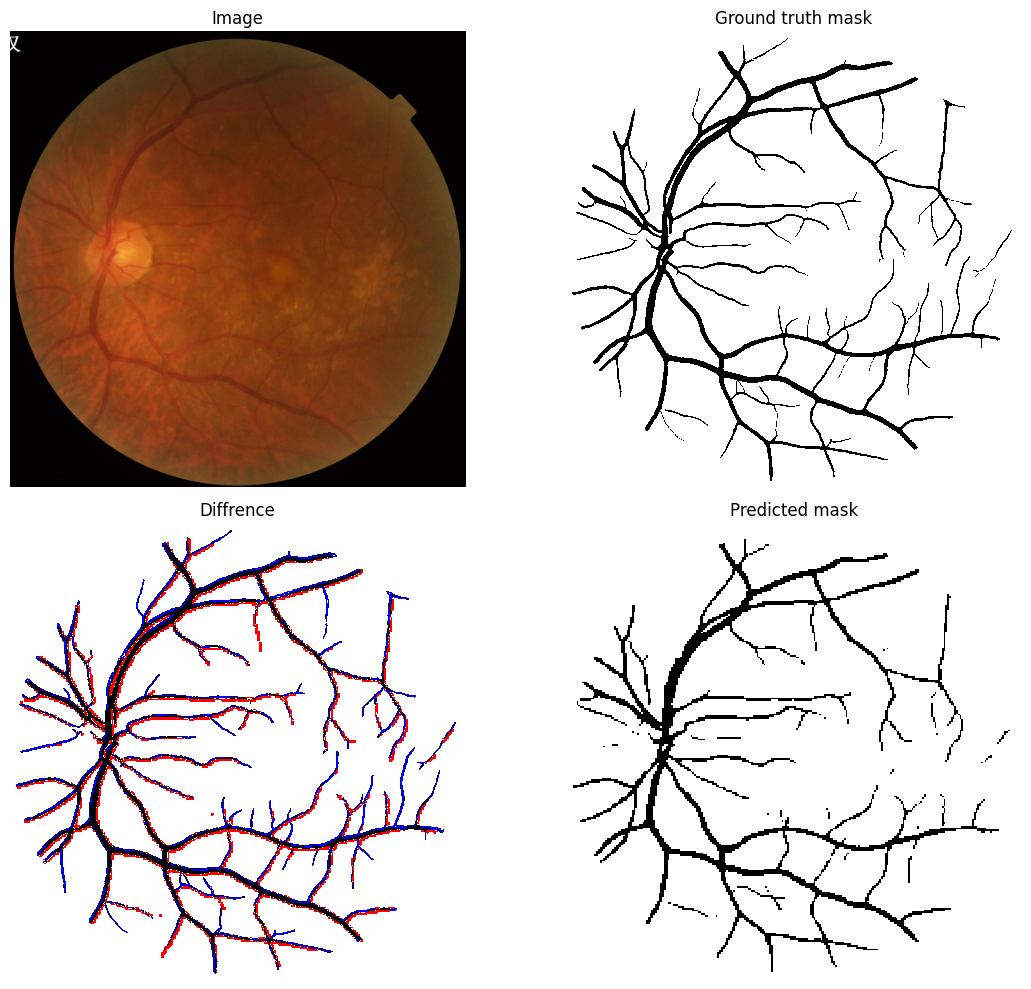

In [123]:
all_img_paths = glob.glob("data/test/img/*")+glob.glob("data/train/img/*")+glob.glob("data/val/img/*")
correct_images_paths = [i for i in all_img_paths if cv2.imread(i) is not None]

random.seed(33)
random.shuffle(correct_images_paths)

images_paths = {'train' : correct_images_paths[:800],
                'val' : correct_images_paths[800:-50],
                'test' : correct_images_paths[-50:],
                }

datasets = {'test' : SegmDataset(images_paths['test'], transform=data_transforms['test'])}
loaders = {'test': DataLoader(datasets['test'], batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True,)}

for nm_model in ['models/UNet11_e35_s256_b9_noaugm', 'models/UNet11_e35_s256_b9_jit']:
    model.load_state_dict(torch.load(nm_model+'.pt'))
    predictions = predict(model)
    predicted_256x256_mask, _, original_height, original_width = predictions[rand_idx]
    full_sized_mask = A.resize(
        predicted_256x256_mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
    )
        
    image_path = images_paths['test'][rand_idx]
    
    figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_path = str(image_path).replace("/img\\", "/segm\\")
    if mask_path.split('\\')[-1][0] !='f' and (mask_path.split('\\')[-1].split('.')[-1] == 'jpg' or mask_path.split('\\')[-1].split('.')
    [-1] == 'JPG'):
        mask_path = mask_path.replace('.jpg', '.tif').replace('.JPG', '.tif')

    mask = plt.imread(mask_path)
    mask = mask/np.max(mask)
    if len(mask.shape) == 3 :mask = mask[:,:,0]
    
    ax[0, 0].imshow(image)
    ax[0, 0].set_title("Image")
    ax[0, 0].set_axis_off()
    ax[0, 1].imshow(mask, interpolation="nearest", cmap='Greys')
    ax[0, 1].set_title("Ground truth mask")
    ax[0, 1].set_axis_off()
    predicted_mask = full_sized_mask
    ax[1, 1].imshow(predicted_mask, interpolation="nearest", cmap='Greys')
    ax[1, 1].set_title("Predicted mask")
    ax[1, 1].set_axis_off()
    cmap, norm = from_levels_and_colors([-5, -.2, .5, 2, 6],['red','white', 'black', 'blue'])
    dif = (mask - predicted_mask)*5+mask
    ax[1, 0].imshow(dif, cmap=cmap, norm=norm)
    ax[1, 0].set_title("Diffrence")
    ax[1, 0].set_axis_off()
    plt.tight_layout()
    plt.show()
    figure.savefig(nm_model+'_viz.jpg')

test: Loss: 0.893 | iou score: 0.002 | f1 score: 0.003 | f2 score: 0.005 | accuracy: 0.917 | recall: 0.030 | precision: 0.002 | specificity: 0.927: 100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


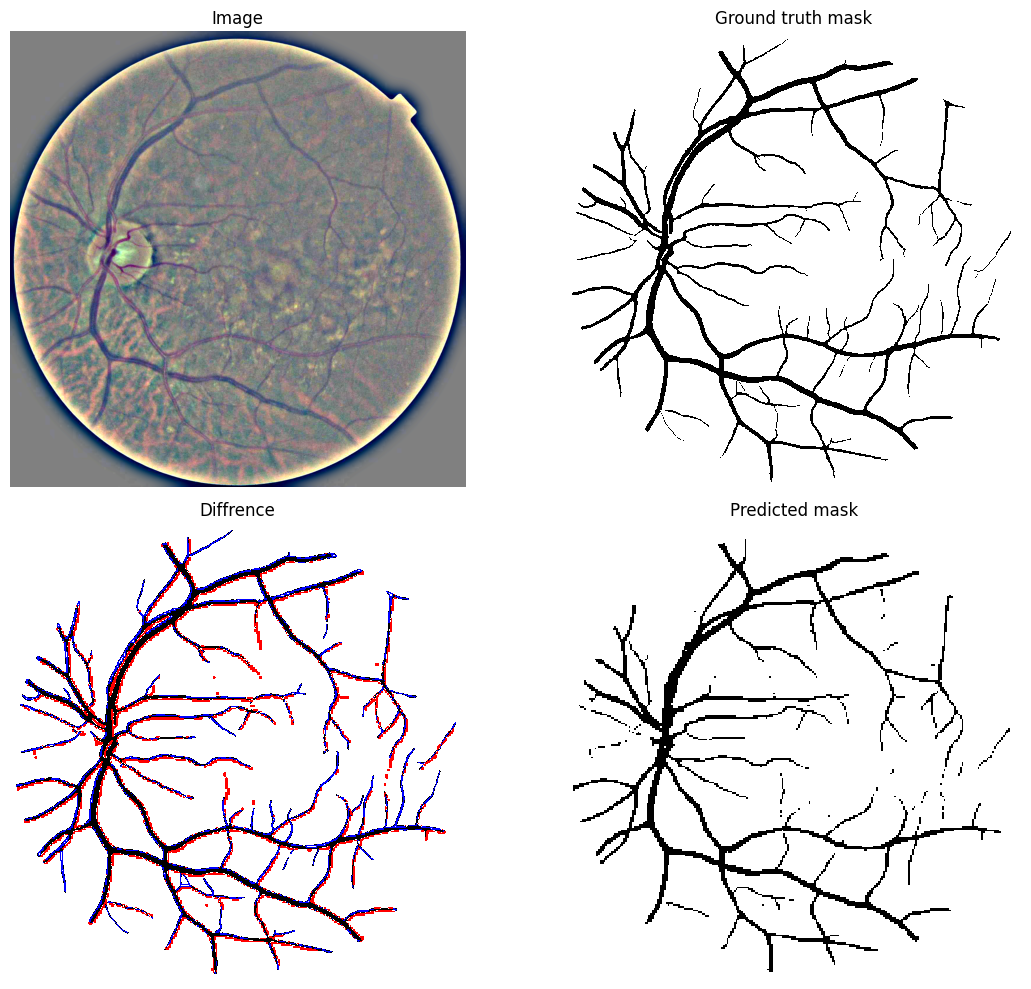

test: Loss: 0.895 | iou score: 0.002 | f1 score: 0.004 | f2 score: 0.006 | accuracy: 0.918 | recall: 0.030 | precision: 0.002 | specificity: 0.928: 100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


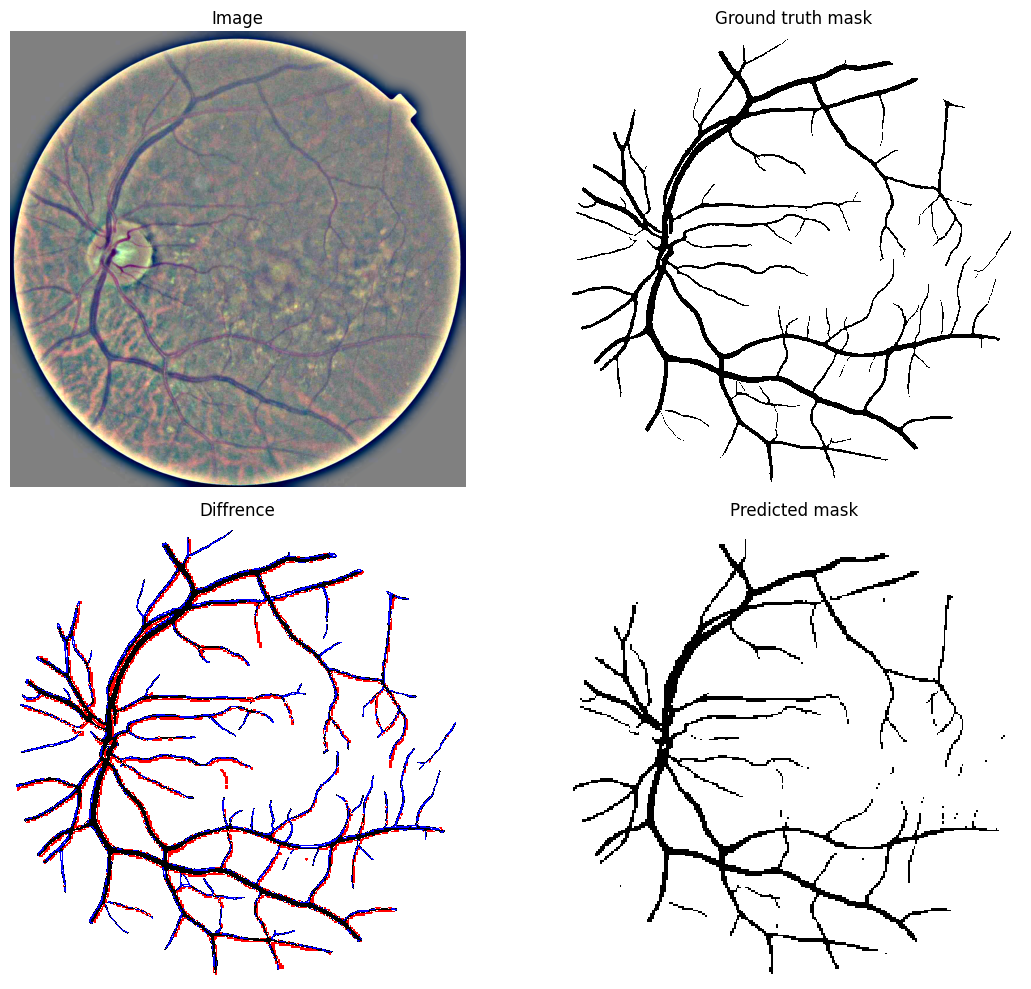

In [124]:
all_img_paths = glob.glob("data/test/img_prep/*")+glob.glob("data/train/img_prep/*")+glob.glob("data/val/img_prep/*")
correct_images_paths = [i for i in all_img_paths if cv2.imread(i) is not None]

random.seed(33)
random.shuffle(correct_images_paths)

images_paths = {'train' : correct_images_paths[:800],
                'val' : correct_images_paths[800:-50],
                'test' : correct_images_paths[-50:],
                }

datasets = {'test' : SegmDataset(images_paths['test'], transform=data_transforms['test'])}
loaders = {'test': DataLoader(datasets['test'], batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True,)}

for nm_model in ['models/UNet11_prep_e35_s256_b9_noaugm', 'models/UNet11_prep_e35_s256_b9_jit']:
    
    model.load_state_dict(torch.load(nm_model+'.pt'))
    predictions = predict(model)

    predicted_256x256_mask, _, original_height, original_width = predictions[rand_idx]
    full_sized_mask = A.resize(
        predicted_256x256_mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
    )        
            
    image_path = images_paths['test'][rand_idx]
    figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_path = str(image_path).replace("/img_prep\\", "/segm\\")
    if mask_path.split('\\')[-1][0] !='f':
        mask_path = mask_path.replace('.jpg', '.tif').replace('.png', '.tif')

    mask = plt.imread(mask_path)
    mask = mask/np.max(mask)
    mask = A.resize(
        mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
    )    
    if len(mask.shape) == 3 :mask = mask[:,:,0]
    
    ax[0, 0].imshow(image)
    ax[0, 0].set_title("Image")
    ax[0, 0].set_axis_off()
    ax[0, 1].imshow(mask, interpolation="nearest", cmap='Greys')
    ax[0, 1].set_title("Ground truth mask")
    ax[0, 1].set_axis_off()
    predicted_mask = full_sized_mask
    ax[1, 1].imshow(predicted_mask, interpolation="nearest", cmap='Greys')
    ax[1, 1].set_title("Predicted mask")
    ax[1, 1].set_axis_off()
    cmap, norm = from_levels_and_colors([-5, -.2, .5, 2, 6],['red','white', 'black', 'blue'])
    dif = (mask - predicted_mask)*5+mask
    ax[1, 0].imshow(dif, cmap=cmap, norm=norm)
    ax[1, 0].set_title("Diffrence")
    ax[1, 0].set_axis_off()
    plt.tight_layout()
    plt.show()
    figure.savefig(nm_model+'_viz.jpg')